# Machine Learning

Written at Atlas Fellowship Summer Program, 15 August 2022.

Building a neural network with NumPy.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Shape

The shape is a `List` of the `len`s: outermost to innermost:
e.g.
```py
>>> np.shape([[[1, 2, 3], [4, 5, 6]]]) == (1, 2, 3)
True
```

In [2]:
train_x = np.random.randint(low=0, high=2, size=(1000, 2))
train_x

array([[0, 0],
       [0, 0],
       [0, 1],
       ...,
       [0, 0],
       [1, 1],
       [1, 1]])

## The Slicing Notation

In [3]:
train_x[:5, 0]

array([0, 0, 0, 1, 1])

In [4]:
train_y = np.expand_dims(train_x[:, 0] & train_x[:, 1], 1)

## Activation Function

Neural networks: we want to approximate any function... but neurons are linear.

Activation functions: introduce non-linearity.

### ReLU

In [5]:
def relu(x):
    return np.maximum(0, x)

In [6]:
relu(train_x - 0.5)

array([[0. , 0. ],
       [0. , 0. ],
       [0. , 0.5],
       ...,
       [0. , 0. ],
       [0.5, 0.5],
       [0.5, 0.5]])

Nice. This implementation works and works with an array.

### Sigmoid

$$
\mathrm{sigmoid}(x) := \frac{1}{1 + \exp(-x)}
$$

Unlike `relu`, `sigmoid` makes the layer's output "the larger, the better" if the goal is to converge to a single target.

In [7]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [8]:
sigmoid(train_x)

array([[0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.73105858],
       ...,
       [0.5       , 0.5       ],
       [0.73105858, 0.73105858],
       [0.73105858, 0.73105858]])

In [9]:
class SimpleNN:
    """Simple neural network:
    x1\
        -> [10] -> [1]
    x2/
    """
    def __init__(self):
        # (input, output) == (2, 10)
        self.l1_weights = np.random.normal(size=(2, 10))
        self.l1_bias = np.random.normal(size=(1, 10))
        # (input, output) == (10, 1)
        self.l2_weights = np.random.normal(size=(10, 1))
        self.l2_bias = np.random.normal(size=(1, 1))
        self.step = {}
    
    def forward(self, x):
        self.step["l1_out"] = (x @ self.l1_weights) + self.l1_bias
        self.step["l1_actv"] = relu(self.step["l1_out"])

        self.step["l2_out"] = (self.step["l1_actv"] @ self.l2_weights) + self.l2_bias
        self.step["l2_actv"] = sigmoid(self.step["l2_out"])
        
        return self.step["l2_actv"]

`@` is a suger for matrix multiplication (it calls `object.__matmul__`):

In [10]:
np.array([1, 2]) @ np.array([[1], [2]])

array([5])

In [11]:
my_nn = SimpleNN()

In [12]:
pred_y_1 = my_nn.forward(train_x)
pred_y_1[:5]

array([[0.94969103],
       [0.94969103],
       [0.81894128],
       [0.94146972],
       [0.94146972]])

In [13]:
def rms_loss(pred_y, y):
    return np.sqrt(np.mean((pred_y - y) ** 2))

In [14]:
rms_loss(pred_y_1, train_y)

0.7914148259409336

We don't need the units to be the same though, so we can omit `sqrt`

In [15]:
def ms_loss(pred_y, y):
    return np.mean((pred_y - y) ** 2)

In [16]:
ms_loss(pred_y_1, train_y)

0.6263374267191182

## Gradient Descent

$$
    \Delta\mathrm{param} = \frac{\partial \mathrm{loss}}{\partial \mathrm{param}}
$$

In [17]:
def d_relu(x):
    return (x > 0).astype(float)

def d_sigmoid(x):
    # Official form:
    # return sigmoid(x) * (1 - sigmoid(x))
    # I want to do it by hand:
    # return -1 * (1. + np.exp(-x)) ** -2 * -1 * np.exp(-x)
    # return (1. + np.exp(-x)) ** -2 * np.exp(-x)
    # We can prove they are equal
    return np.exp(x) / (1. + np.exp(x)) ** 2

def d_ms_loss(pred_y, y):
    return np.mean(2 * (pred_y - y))

Create a new NN:

In [18]:
nn = SimpleNN()
all_total_losses = []

In [19]:
learning_rate = 0.001
max_epoch = 100

for epoch in range(max_epoch):
    total_loss = 0
    for (x, y) in zip(train_x, train_y):
        cur_pred_y = nn.forward(x)
        cur_loss = ms_loss(cur_pred_y, y)
        total_loss += cur_loss

        # Loss := loss(L2actv - y)
        par_loss_par_l2actv = d_ms_loss(nn.step["l2_actv"], y)
        # L2actv := L2actv(L2out)
        par_l2actv_par_l2out = d_sigmoid(nn.step["l2_out"])
        # L2out := L1actv @ weights2 + bias2
        par_l2out_par_bias2 = 1
        par_l2out_par_weights2 = nn.step["l1_actv"].T
        par_l2out_par_l1actv = nn.l2_weights.T
        # L1actv := L1actv(L1out)
        par_l1actv_par_l1out = d_relu(nn.step["l1_out"])
        # L1out := x @ weights1 + bias1
        par_l1out_par_bias1 = 1
        par_l1out_par_weights1 = np.expand_dims(x, 1)
        
        # Now we use the chain rule
        par_loss_par_bias2 = par_loss_par_l2actv * par_l2actv_par_l2out \
            * par_l2out_par_bias2
        par_loss_par_weights2 = par_loss_par_l2actv * par_l2actv_par_l2out \
            * par_l2out_par_weights2
        par_loss_par_bias1 = par_loss_par_l2actv * par_l2actv_par_l2out \
            * par_l2out_par_l1actv * par_l1actv_par_l1out * par_l1out_par_bias1
        par_loss_par_weights1 = par_loss_par_l2actv * par_l2actv_par_l2out \
            * par_l2out_par_l1actv * par_l1actv_par_l1out * par_l1out_par_weights1

        # Then, we update the weights and biases
        nn.l2_bias -= learning_rate * par_loss_par_bias2
        nn.l2_weights -= learning_rate * par_loss_par_weights2
        nn.l1_bias -= learning_rate * par_loss_par_bias1
        nn.l1_weights -= learning_rate * par_loss_par_weights1
    all_total_losses.append(total_loss)

Let's hope that the loss decreses over time:

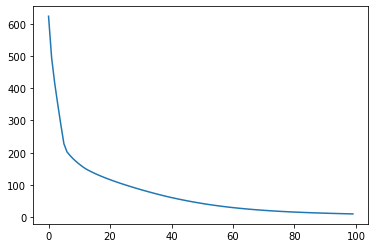

In [20]:
plt.plot(all_total_losses)

In [21]:
np.round(nn.forward([[0, 0], [1, 0], [0, 1], [1, 1]]))

array([[0.],
       [0.],
       [0.],
       [1.]])

## Convolutional Layer

A convolutional layer is a function (kernel function) that applies to some consecutive outputs of the previous layer (or the input). For example, if the previous layer outputs
```py
[1, 8, 9, -2, 3, 4, 8, 5]
```
and in the convolutional layer, we multiply each pair of inputs with `[1, -1]`, we get
```py
[1 - 8, 8 - 9, 9 + 2, -2 - 3, 3 - 4, 4 - 8, 8 - 5]
```